In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!mkdir -p /content/myplants
!unzip "/content/drive/MyDrive/dataset/plantDataset.zip" -d "/content/myplants"


Streaming output truncated to the last 5000 lines.
  inflating: /content/myplants/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: /content/myplants/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: /content/myplants/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: /content/myplants/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: /content/myplants/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4

In [ ]:
base_dir = "/content/plantvillage/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = base_dir + "/train"
val_dir = base_dir + "/valid"

print(train_dir)
print(val_dir)


/content/plantvillage/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
/content/plantvillage/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

print("classes:", len(train_dataset.classes))
print(train_dataset.classes[:10])


classes: 38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']


In [ ]:
train_dir = "/content/myplants/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/myplants/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"


In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

len(train_dataset), len(valid_dataset)


(70295, 17572)

In [ ]:
model = models.resnet18(weights="IMAGENET1K_V1")

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)


In [ ]:
num_epochs = 8
best_val_loss = float("inf")
patience = 2
streak = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
            _, pred = torch.max(out, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()

    avg_train = running_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    acc = 100 * correct / total

    print(f"epoch {epoch+1}, train: {avg_train:.4f}, val: {avg_val:.4f}, acc: {acc:.2f}")

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        streak = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        streak += 1
        if streak >= patience:
            print("early stopping")
            break


epoch 1, train: 1.5876, val: 0.6820, acc: 88.74
epoch 2, train: 0.5548, val: 0.3857, acc: 91.96
epoch 3, train: 0.3734, val: 0.2949, acc: 93.12
epoch 4, train: 0.2961, val: 0.2508, acc: 93.80
epoch 5, train: 0.2526, val: 0.2203, acc: 94.44
epoch 6, train: 0.2243, val: 0.1947, acc: 94.87
epoch 7, train: 0.2059, val: 0.1829, acc: 95.15
epoch 8, train: 0.1907, val: 0.1724, acc: 95.27


predicted: Apple___Apple_scab


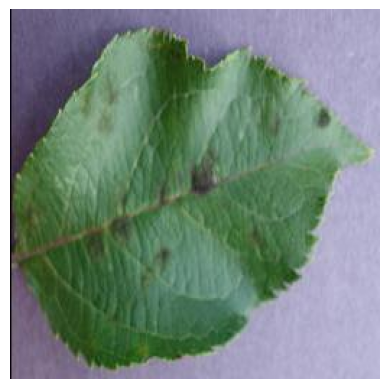

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

img_path, _ = val_dataset.samples[0]
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')

img_t = transform(img).unsqueeze(0).to(device)
with torch.no_grad():
    out = model(img_t)
    prob = F.softmax(out, dim=1)
    pred = torch.argmax(prob).item()

print("predicted:", train_dataset.classes[pred])


In [ ]:
from google.colab import files
files.download("best_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>